In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import re
import seaborn as sns
import tempfile
import subprocess
import os
from scipy import stats

def statistics_columns(df, col1, col2, paired=False, alpha=0.05, treshold = 0):
    x = df[col1].dropna().reset_index(drop=True)
    y = df[col2].dropna().reset_index(drop=True)
    # Ensure same length for paired tests
    if paired and len(x) != len(y):
        raise ValueError("For paired tests, both columns must have the same number of observations")

    # Normality tests
    p_norm_x = stats.shapiro(x)[1]
    p_norm_y = stats.shapiro(y)[1]
    normal = (p_norm_x > alpha) and (p_norm_y > alpha)

    # Determine which test to run
    if paired:
        if normal:
            test_stat, p = stats.ttest_rel(x, y)
            test_name = "Paired t-test"
            effect_size = (x - y).mean() / (x - y).std(ddof=1)  # Cohen's d for paired
        else:
            test_stat, p = stats.wilcoxon(x, y)
            test_name = "Wilcoxon signed-rank"
            effect_size = (x > y).mean() - (x < y).mean()  # Rank biserial
    else:
        # Check variance homogeneity
        equal_var = stats.levene(x, y).pvalue > alpha

        if normal:
            test_stat, p = stats.ttest_ind(x, y, equal_var=equal_var)
            test_name = "Unpaired t-test" if equal_var else "Welch’s t-test"
            # Pooled standard deviation
            pooled_std = np.sqrt(((len(x)-1)*np.std(x, ddof=1)**2 + (len(y)-1)*np.std(y, ddof=1)**2) / (len(x) + len(y) - 2))
            effect_size = (np.mean(x) - np.mean(y)) / pooled_std  # Cohen's d
        else:
            test_stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')
            test_name = "Mann–Whitney U"
            # Rank biserial approximation
            n1, n2 = len(x), len(y)
            U = test_stat
            effect_size = 1 - (2 * U) / (n1 * n2)
    
    if p > 0.05 :
        star = "ns"
    elif p < 0.05 and p > 0.01 :
        star = "*"
    elif p < 0.01 and p > 0.001 :
        star = "**"
    else:
        star = "***"
    
    return {
        "test": test_name,
        "p_value": p,
        "star": star,
        "statistic": test_stat,
        f"mean {col1}" : np.mean(x),
        f"mean {col2}" : np.mean(y),
        f"over_treshold {col1}" : len(df[df[col1] > treshold]),
        f"over_treshold {col2}" : len(df[df[col2] > treshold]),
        f"times {col1} > {col2}" : (df[col1] > df[col2]).sum(),
        f"times {col2} > {col1}" : (df[col2] > df[col1]).sum(),
        "mean_difference": np.mean(x) - np.mean(y),
        "effect_size": effect_size,
        "normality": {"col1": p_norm_x, "col2": p_norm_y},
        "equal_variance": equal_var if not paired else None
    }


In [2]:

def boxplot(df,col_list,value,palette,tittle,y_lab,fig_size):
    # Prepare long-format data
    stab_long = df[col_list].melt(var_name="Condition", value_name=value)

    # Set style
    sns.set(style="whitegrid", context="notebook")

    # Define a color palette that you can re-use

    plt.figure(figsize=fig_size)

    # Boxplot with mean marker
    ax = sns.boxplot(
        x="Condition",
        y=value,
        data=stab_long,
        width=0.4,
        palette=palette,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "black",
            "markeredgecolor": "black",
            "markersize": 6
        },
        zorder = 2
    )

    # Overlay individual points, colored by condition
    sns.stripplot(
        x="Condition",
        y=value,
        data=stab_long,
        jitter=True,
        dodge=False,
        palette=palette,
        alpha=0.7,
        zorder = 1
    )

    # Annotate the mean values as text
    mean_values = stab_long.groupby("Condition")[value].mean()
    xticks = dict(zip(ax.get_xticklabels(), ax.get_xticks()))
    for condition, mean in mean_values.items():
        xpos = xticks.get(condition)
        if xpos is not None:
            ax.text(
                xpos,
                mean + 0.3,
                f"{mean:.2f}",
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                zorder=4
            )
    # Add breathing space above and below
    y_min = stab_long[value].min()
    y_max = stab_long[value].max()
    y_margin = (y_max - y_min) * 0.1
    plt.ylim(y_min - y_margin, y_max + y_margin)
    # Final touches
    plt.title(tittle)
    plt.ylabel(y_lab)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
    return

def plot_paired(df, col_wo, col_w, tittle, xlabel,label_wo,label_w,order_by,size =(10,18)): 
    # Order by file_ID
    df = df.sort_values(by= order_by, ascending=False).reset_index(drop=True)

    # Generate y positions
    y_pos = range(len(df))
    file_ids = df['file_ID']

    # Start plotting
    plt.figure(figsize= size)
    for i, row in df.iterrows():
        plt.plot([row[col_wo], row[col_w]], [i, i], 'gray', alpha=0.4)

    plt.scatter(df[col_wo], y_pos, color='red', label=label_wo)
    plt.scatter(df[col_w], y_pos, color='blue', label=label_w)

    plt.yticks(ticks=y_pos, labels=file_ids)
    plt.xlabel(xlabel)
    plt.ylabel("Sample")
    plt.title(tittle)
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    return



def plot_paired_multicolumn(df, cols, title, xlabel, labels, order_by):
    """
    df: dataframe con los datos
    cols: lista con los 6 nombres de columnas a plotear, e.g. ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
    title: título del gráfico
    xlabel: label para el eje x
    labels: lista con los 6 labels para la leyenda
    order_by: columna para ordenar las filas
    """

    # Ordenar dataframe
    df = df.sort_values(by=order_by, ascending=False).reset_index(drop=True)

    y_pos = range(len(df))
    file_ids = df['file_ID']

    plt.figure(figsize=(12, max(6, len(df)*0.5)))

    for i, row in df.iterrows():
        # Obtener los valores para las 6 columnas
        values = [row[c] for c in cols]
        # Graficar líneas entre cada punto consecutivo para la fila i
        plt.plot(values, [i]*6, color='gray', alpha=0.4)

    # Graficar puntos
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  # colores para 6 puntos
    for j, c in enumerate(cols):
        plt.scatter(df[c], y_pos, color=colores[j], label=labels[j])

    plt.yticks(ticks=y_pos, labels=file_ids)
    plt.xlabel(xlabel)
    plt.ylabel("Sample")
    plt.title(title)
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_paired_multicolor(df, col_wo, col_w, title, xlabel, order_by, color_labels, size=(10, 18)): 
    # Ordenar por columna indicada
    df = df.sort_values(by=order_by, ascending=False).reset_index(drop=True)

    # Posiciones en el eje Y
    y_pos = range(len(df))
    file_ids = df['file_ID']

    # Iniciar figura
    plt.figure(figsize= size)

    for i, row in df.iterrows():
        # Línea gris entre puntos
        plt.plot([row[col_wo], row[col_w]], [i, i], color='gray', alpha=0.4)
        # Puntos con colores individuales
        plt.scatter(row[col_wo], i, color=row['color_wo'])
        plt.scatter(row[col_w], i, color=row['color_w'])

    # Ejes y título
    plt.yticks(ticks=list(y_pos), labels=file_ids)
    plt.xlabel(xlabel)
    plt.ylabel("Sample")
    plt.title(title)
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)


    #legend_elements = [Patch(facecolor=color, label=label) for label, color in color_labels.items()]
    #plt.legend(handles=legend_elements, title="Group")

    plt.tight_layout()
    plt.show()

In [3]:
def oligomer_paired_and_boxes(dimer_df, trimer_df, pentamer_df, column_w,column_wo, x_label, tittle ,ordering, size = (10, 18)):
    # Ordenar y limpiar file_IDs
    for df in [dimer_df, trimer_df, pentamer_df]:
        df['file_ID'] = df['file_ID'].str.split('.pdb').str[0]
        df.sort_values(by='file_ID', inplace=True)

    # Filtrar por IDs comunes
    common_ids = set(dimer_df['file_ID']) & set(trimer_df['file_ID']) & set(pentamer_df['file_ID'])
    dimer_df = dimer_df[dimer_df['file_ID'].isin(common_ids)].reset_index(drop=True)
    trimer_df = trimer_df[trimer_df['file_ID'].isin(common_ids)].reset_index(drop=True)
    pentamer_df = pentamer_df[pentamer_df['file_ID'].isin(common_ids)].reset_index(drop=True)

    # Paleta de colores
    palette = {
        "dimer_w": "#d62728",     # rojo fuerte
        "dimer_wo": "#ff9896",    # rojo suave
        "trimer_w": "#2ca02c",    # verde fuerte
        "trimer_wo": "#98df8a",   # verde suave
        "pentamer_w": "#1f77b4",  # azul fuerte
        "pentamer_wo": "#aec7e8"  # azul suave
    }

    # Construir filas
    rows = []
    for i in range(len(dimer_df)):
        pLDDT_dict = {
            "dimer_w": dimer_df.loc[i, column_w],
            "dimer_wo": dimer_df.loc[i, column_wo],
            "trimer_w": trimer_df.loc[i, column_w],
            "trimer_wo": trimer_df.loc[i, column_wo],
            "pentamer_w": pentamer_df.loc[i, column_w],
            "pentamer_wo": pentamer_df.loc[i, column_wo]
        }

        max_key = max(pLDDT_dict, key=pLDDT_dict.get)
        mer_type = max_key.split("_")[0]

        # Buscar la clave complementaria
        pair_key = [k for k in pLDDT_dict if mer_type in k and k != max_key][0]

        # Asignar valores y colores
        if "wo" in max_key:
            pLDDT_wo = pLDDT_dict[max_key]
            pLDDT_w = pLDDT_dict[pair_key]
            key_wo = max_key
            key_w = pair_key
        else:
            pLDDT_w = pLDDT_dict[max_key]
            pLDDT_wo = pLDDT_dict[pair_key]
            key_w = max_key
            key_wo = pair_key

        color_w = palette[key_w]
        color_wo = palette[key_wo]

        row = [
            dimer_df.loc[i, 'file_ID'],
            mer_type,
            pLDDT_w,
            pLDDT_wo,
            color_w,
            color_wo
        ]
        rows.append(row)

    processed_df = pd.DataFrame(rows, columns=[
        'file_ID', 'mer_type', column_w, column_wo, 'color_w', 'color_wo'
    ])

    # Llamar a la función de ploteo
    plot_paired_multicolor(
        processed_df,
        col_wo=column_wo,
        col_w= column_w,
        title= tittle,
        xlabel=x_label,
        order_by=ordering,  # o 'file_ID' si prefieres
        color_labels=palette,
        size= size
    )

    return processed_df

def count_samples_above_threshold(dfs, column, threshold):
    """
    Count unique samples (by 'file_ID') with a value above threshold in at least one dataframe.

    Parameters:
        dfs (list of pd.DataFrame): List of dataframes containing the column and 'file_ID'.
        column (str): Name of the column to evaluate.
        threshold (float): Threshold value.

    Returns:
        int: Number of unique samples above the threshold in at least one dataframe.
    """
    matching_ids = set()

    for df in dfs:
        matching = df[df[column] > threshold]["file_ID"]
        matching_ids.update(matching)

    return len(matching_ids)

# OLIGOMERS

In [4]:
# Load dataframe
dimer_df = pd.read_csv("/home/eduardo/benchmark_output_04-07_def/dimer_metrics.csv")
trimer_df = pd.read_csv("/home/eduardo/benchmark_output_04-07_def/trimer_metrics.csv")
pentamer_df = pd.read_csv("/home/eduardo/benchmark_output_04-07_def/pentamer_metrics.csv")

dimer_df['file_ID'] = dimer_df['file_ID'].str.split('.pdb').str[0]
trimer_df['file_ID'] = trimer_df['file_ID'].str.split('.pdb').str[0]
pentamer_df['file_ID'] = pentamer_df['file_ID'].str.split('.pdb').str[0]
dimer_df = dimer_df.sort_values(by = "file_ID",axis = 0)
trimer_df = trimer_df.sort_values(by = "file_ID",axis = 0)
pentamer_df = pentamer_df.sort_values(by = "file_ID",axis = 0)
# Order by file_ID
pentamer_df.head(10)


,Unnamed: 0,file_ID,RMSD_pred-ex_w,Tm_pred-ex_w,RMSD_pred-ex_wo,Tm_pred-ex_wo,RMSD_w_wo,Tm_w_wo,pLDDT_w,pLDDT_wo
51,0,afm_1j5wb02_0,8.174441,0.25360,21.425325,0.53445,24.777313,0.30879,82.226981,77.410943
64,0,afm_1xawa01_1,53.720791,0.14882,28.341370,0.29142,33.066948,0.20233,62.565165,77.564141
5,0,afm_1z08c00_6,25.877567,0.47525,24.974762,0.22136,30.732904,0.24686,84.720979,77.037445
18,0,afm_2aq6a00_5,28.322691,0.20903,22.887360,0.26530,29.958647,0.25770,61.339563,81.853352
57,0,afm_2x49a03_7,6.772994,0.66905,26.053619,0.16275,3.474097,0.22558,72.703846,64.153511
40,0,afm_3adga00_8,27.637177,0.18771,25.552505,0.26203,23.294477,0.24997,80.917567,74.177556
49,0,afm_3f9ua00_6,30.575886,0.21042,23.581385,0.19130,9.288360,0.14225,61.460565,48.928088
42,0,afm_3gdwa00_5,24.588076,0.20982,4.776039,0.78932,25.115170,0.30631,43.322736,71.212274
25,0,afm_3onja00_7,37.309155,0.13563,25.809761,0.25636,30.105698,0.21464,56.931001,78.007191
8,0,afm_3w6va00_1,27.628962,0.33347,21.127897,0.34264,29.425144,0.23320,83.189739,85.863874


In [7]:
match_plddt_w = count_samples_above_threshold([dimer_df,trimer_df,pentamer_df],"pLDDT_w",80)
match_tmscore_w = count_samples_above_threshold([dimer_df,trimer_df,pentamer_df],"Tm_pred-ex_w",0.4)
match_plddt_wo = count_samples_above_threshold([dimer_df,trimer_df,pentamer_df],"pLDDT_wo",80)
match_tmscore_wo = count_samples_above_threshold([dimer_df,trimer_df,pentamer_df],"Tm_pred-ex_wo",0.4)
print(match_plddt_w)
print(match_plddt_wo)
print(match_tmscore_w)
print(match_tmscore_wo)

45
79
61
74


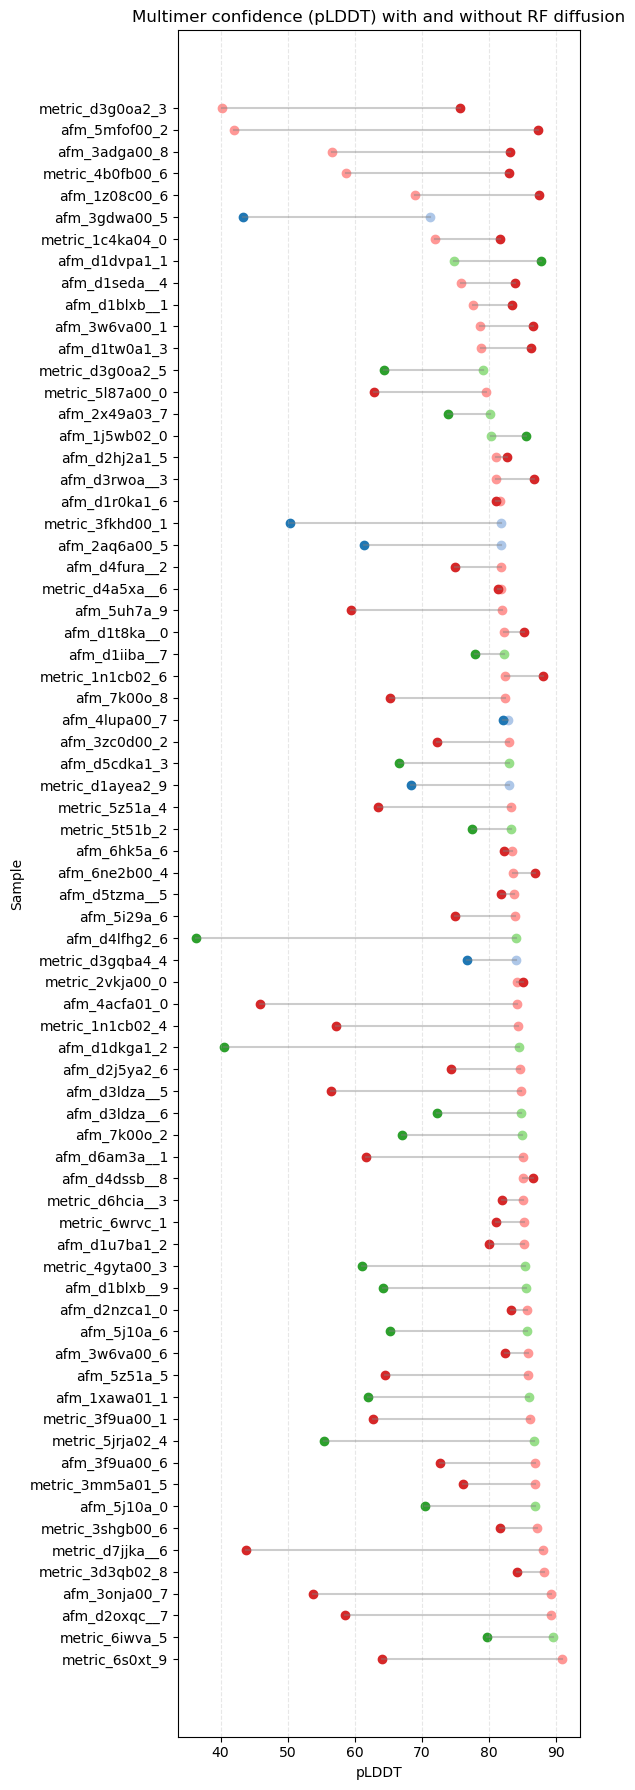

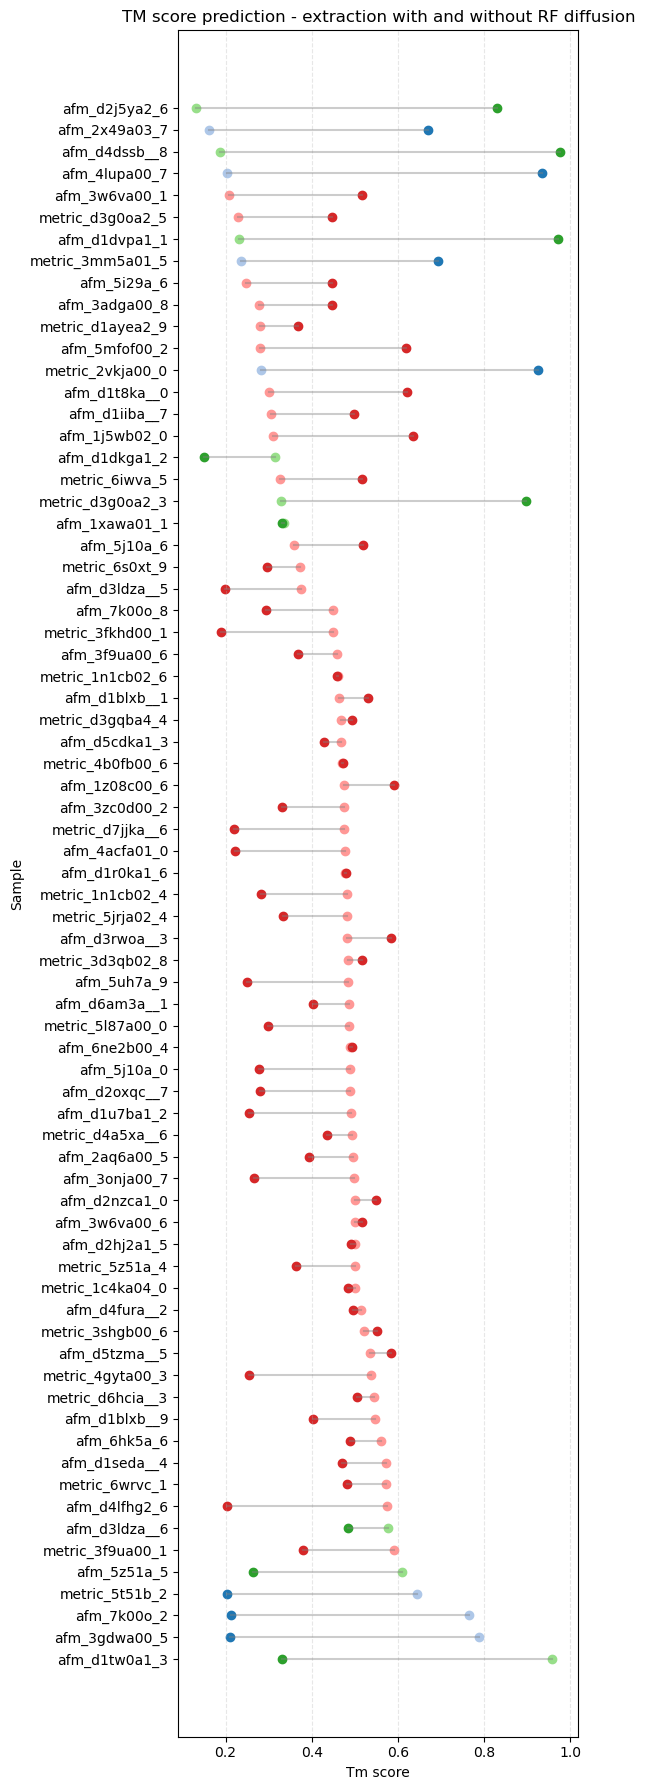

In [14]:
oligomer_df = oligomer_paired_and_boxes(dimer_df,trimer_df,pentamer_df,'pLDDT_w','pLDDT_wo','pLDDT',"Multimer confidence (pLDDT) with and without RF diffusion", 'pLDDT_wo',(6,18))
oligomer_tm = oligomer_paired_and_boxes(dimer_df,trimer_df,pentamer_df,'Tm_pred-ex_w','Tm_pred-ex_wo','Tm score',"TM score prediction - extraction with and without RF diffusion", 'Tm_pred-ex_wo',(6,18))

In [12]:
oligomer_plddt = statistics_columns(oligomer_df,'pLDDT_w','pLDDT_wo', paired = True)
oligomer_tm = statistics_columns(oligomer_tm,'Tm_pred-ex_w','Tm_pred-ex_wo', paired = True)
print(oligomer_plddt)
print(oligomer_tm)

{'test': 'Wilcoxon signed-rank', 'p_value': 2.9785524685102833e-05, 'star': '***', 'statistic': 570.0, 'mean pLDDT_w': 72.18517423981012, 'mean pLDDT_wo': 81.36004713884523, 'over_treshold pLDDT_w': 72, 'over_treshold pLDDT_wo': 72, 'times pLDDT_w > pLDDT_wo': 19, 'times pLDDT_wo > pLDDT_w': 53, 'mean_difference': -9.174872899035108, 'effect_size': -0.47222222222222227, 'normality': {'col1': 7.139899449290698e-05, 'col2': 3.6187803268989367e-12}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 0.4622592008553318, 'star': 'ns', 'statistic': 1183.0, 'mean Tm_pred-ex_w': 0.45267902777777774, 'mean Tm_pred-ex_wo': 0.44594138888888885, 'over_treshold Tm_pred-ex_w': 72, 'over_treshold Tm_pred-ex_wo': 72, 'times Tm_pred-ex_w > Tm_pred-ex_wo': 31, 'times Tm_pred-ex_wo > Tm_pred-ex_w': 41, 'mean_difference': 0.006737638888888897, 'effect_size': -0.13888888888888884, 'normality': {'col1': 0.00019516401924704748, 'col2': 0.0004194294414903181}, 'equal_variance': None}


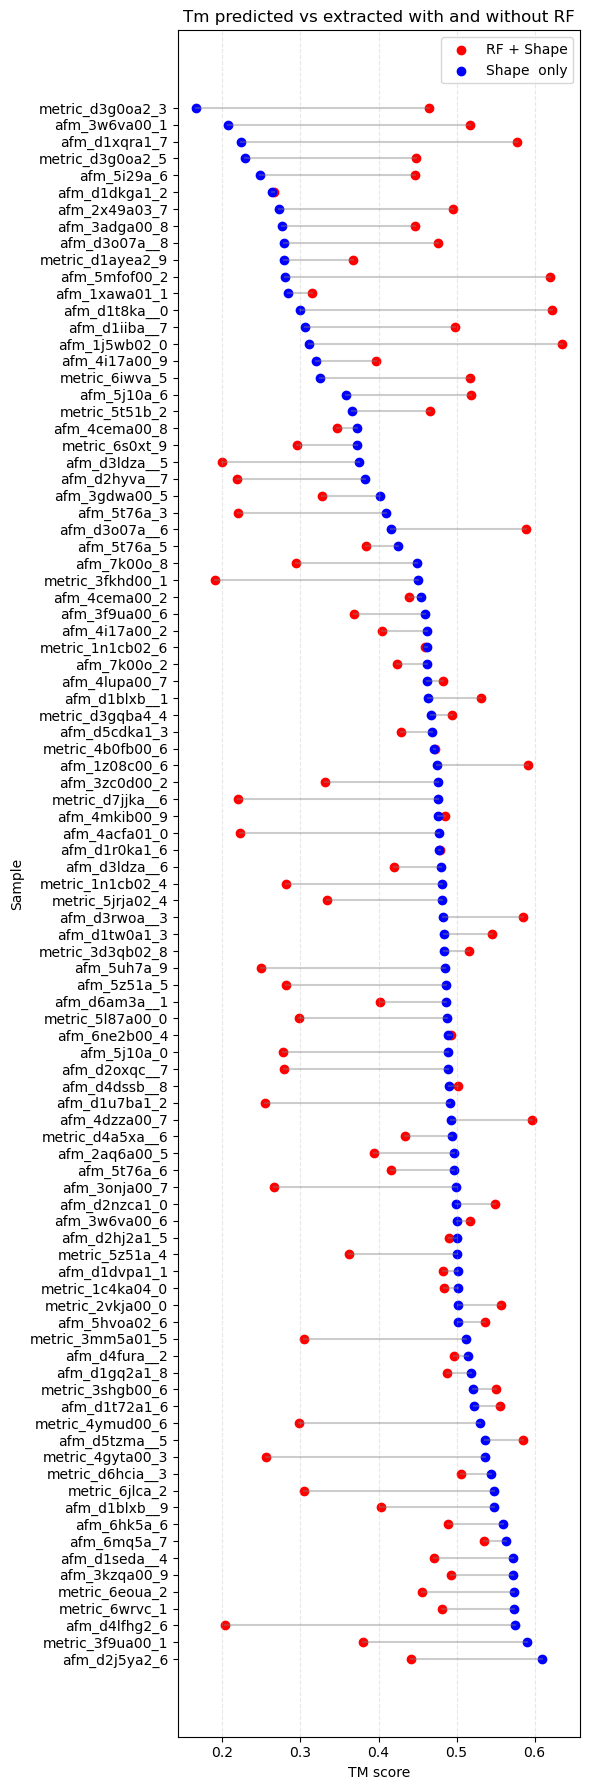

In [19]:
plot_paired(dimer_df,"Tm_pred-ex_w","Tm_pred-ex_wo","Tm predicted vs extracted with and without RF","TM score","RF + Shape","Shape  only","Tm_pred-ex_wo", size = (6,18))


In [ ]:
#plot_paired(dimer_df,"interface_w","interface_wo","Dimer binding energy w and wo RF diffusion","Binding energy (kcal/mol)","RF+shape","shape_design only","interface_wo")


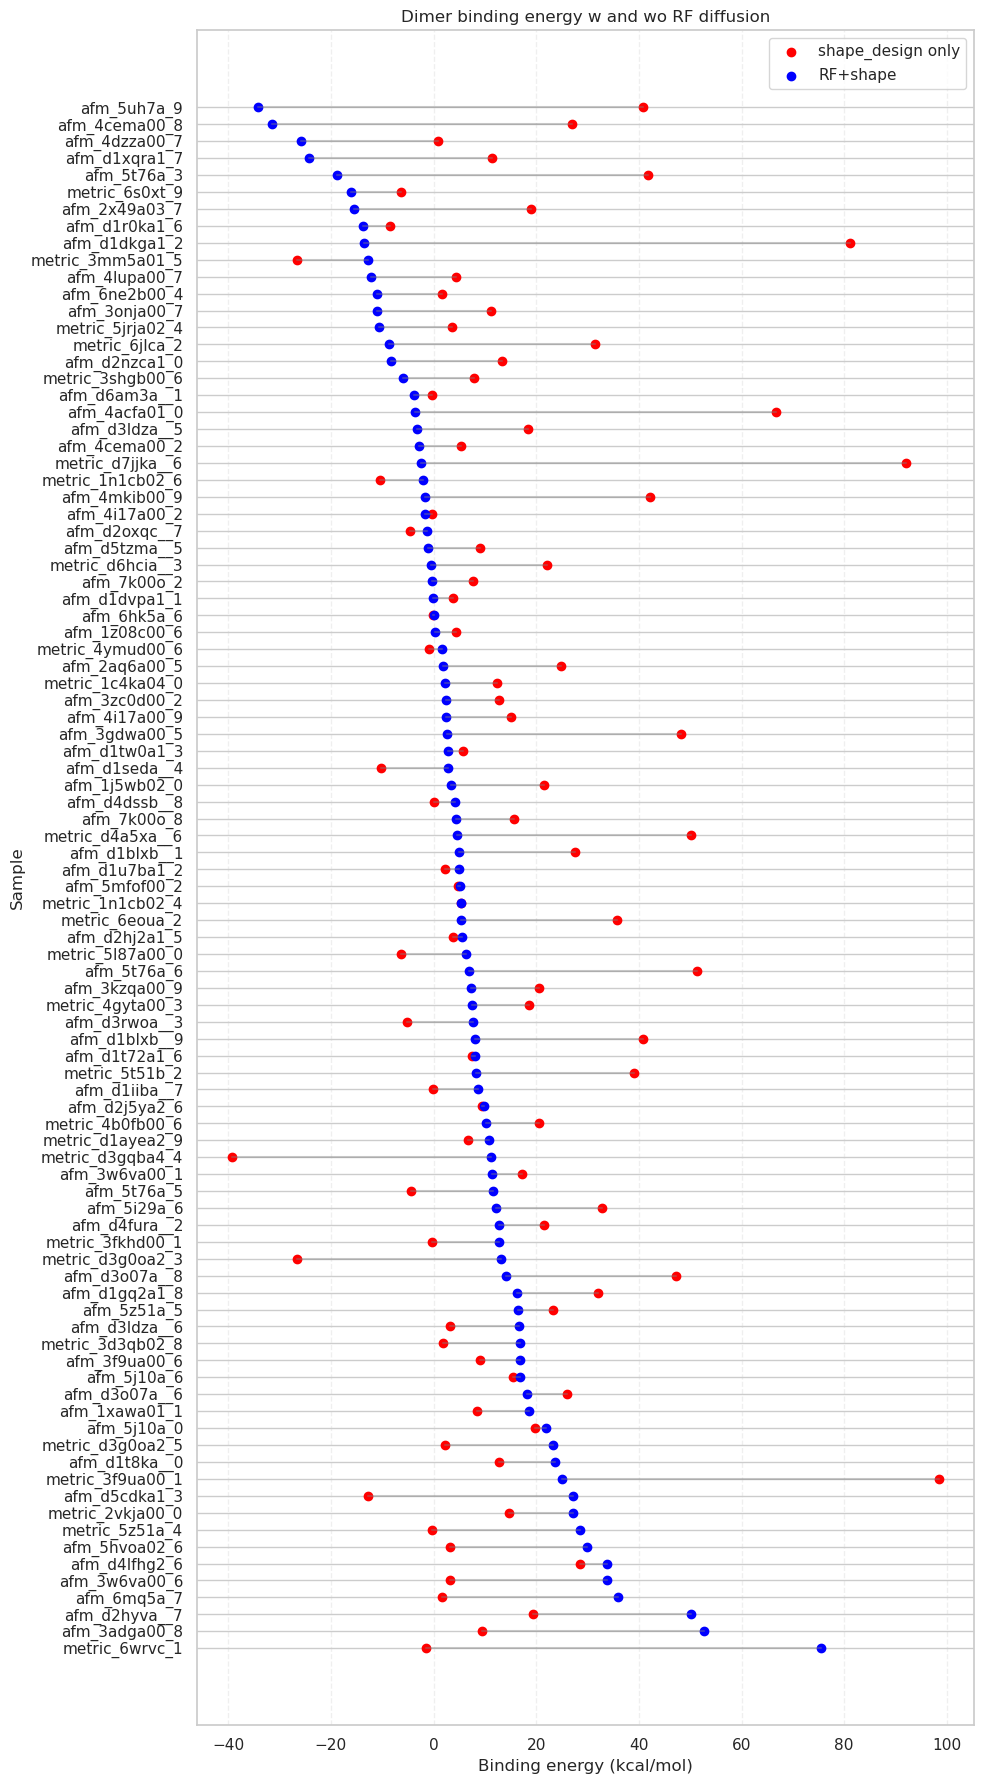

In [ ]:
dimer_df = dimer_df[dimer_df['file_ID'] != 'metric_6iwva_5']
plot_paired(dimer_df,"interface_w","interface_wo","Dimer binding energy w and wo RF diffusion","Binding energy (kcal/mol)","shape_design only","RF+shape","interface_wo")


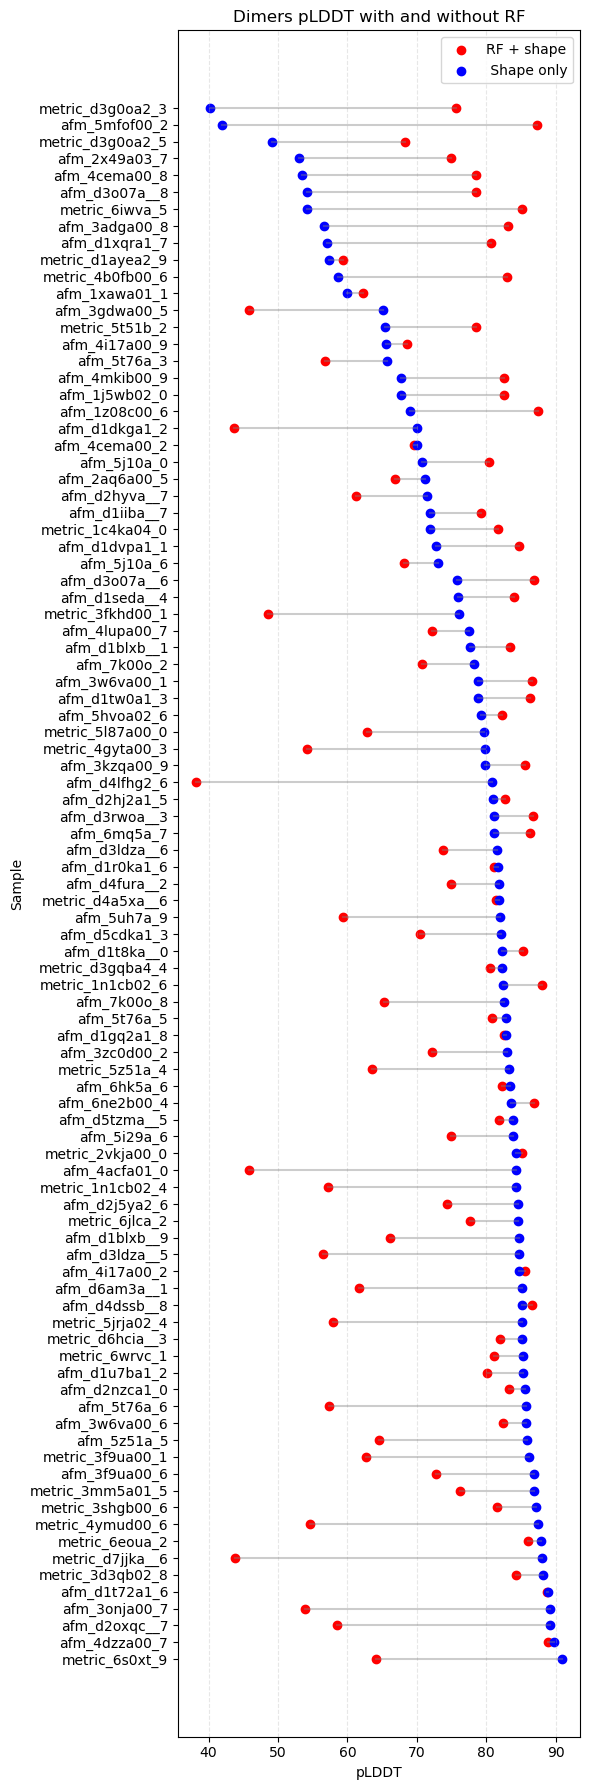

In [16]:
plot_paired(dimer_df,"pLDDT_w","pLDDT_wo","Dimers pLDDT with and without RF","pLDDT","RF + shape"," Shape only","pLDDT_wo",size=(6,18))


# TRIMERS & PENTAMERS

In [ ]:
trimer_df = pd.read_csv("/home/eduardo/benchmark_output_23-06/trimer_metrics.csv")
pentamer_df = pd.read_csv("/home/eduardo/benchmark_output_23-06/pentamer_metrics.csv")
trimer_df['file_ID'] = pentamer_df['file_ID'].str.split('.pdb').str[0]
pentamer_df['file_ID'] = pentamer_df['file_ID'].str.split('.pdb').str[0]

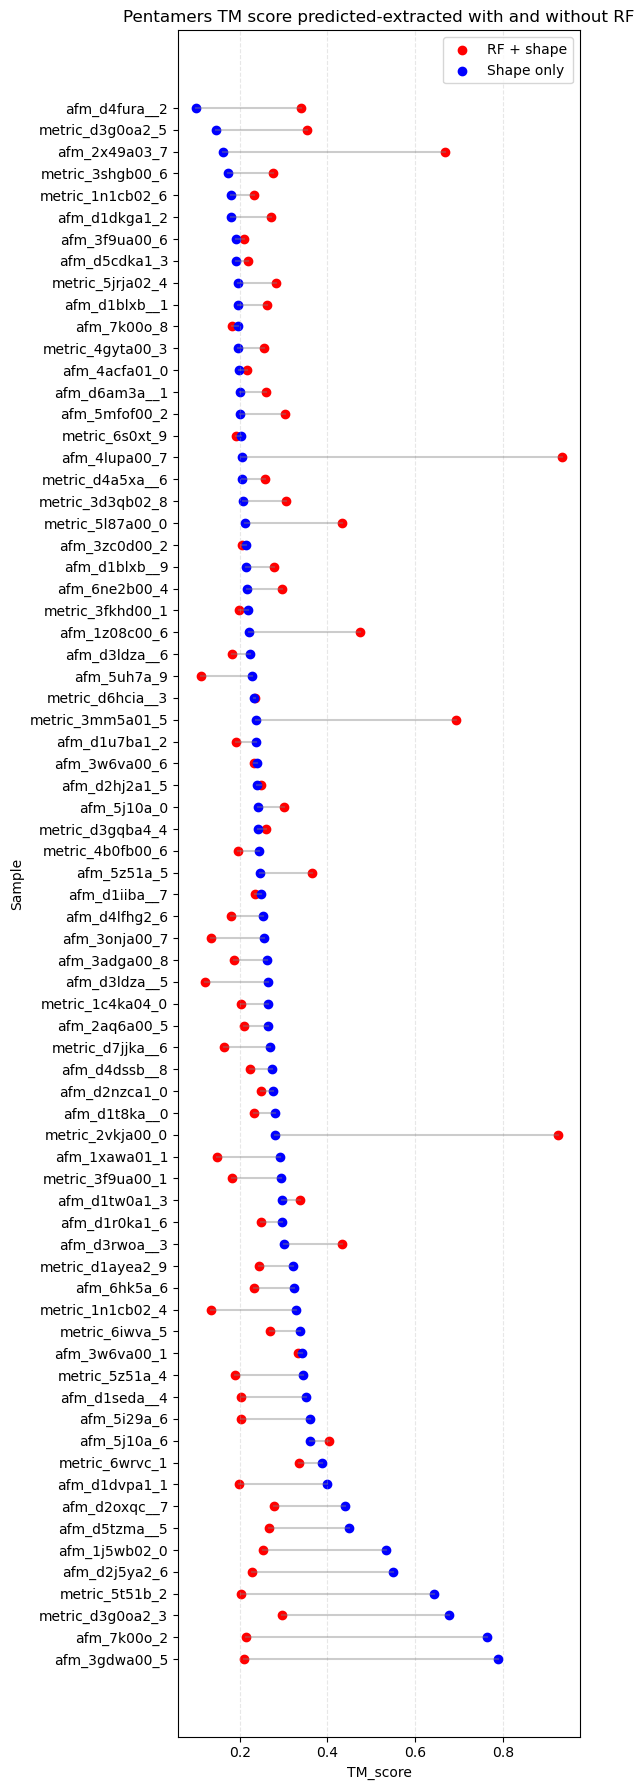

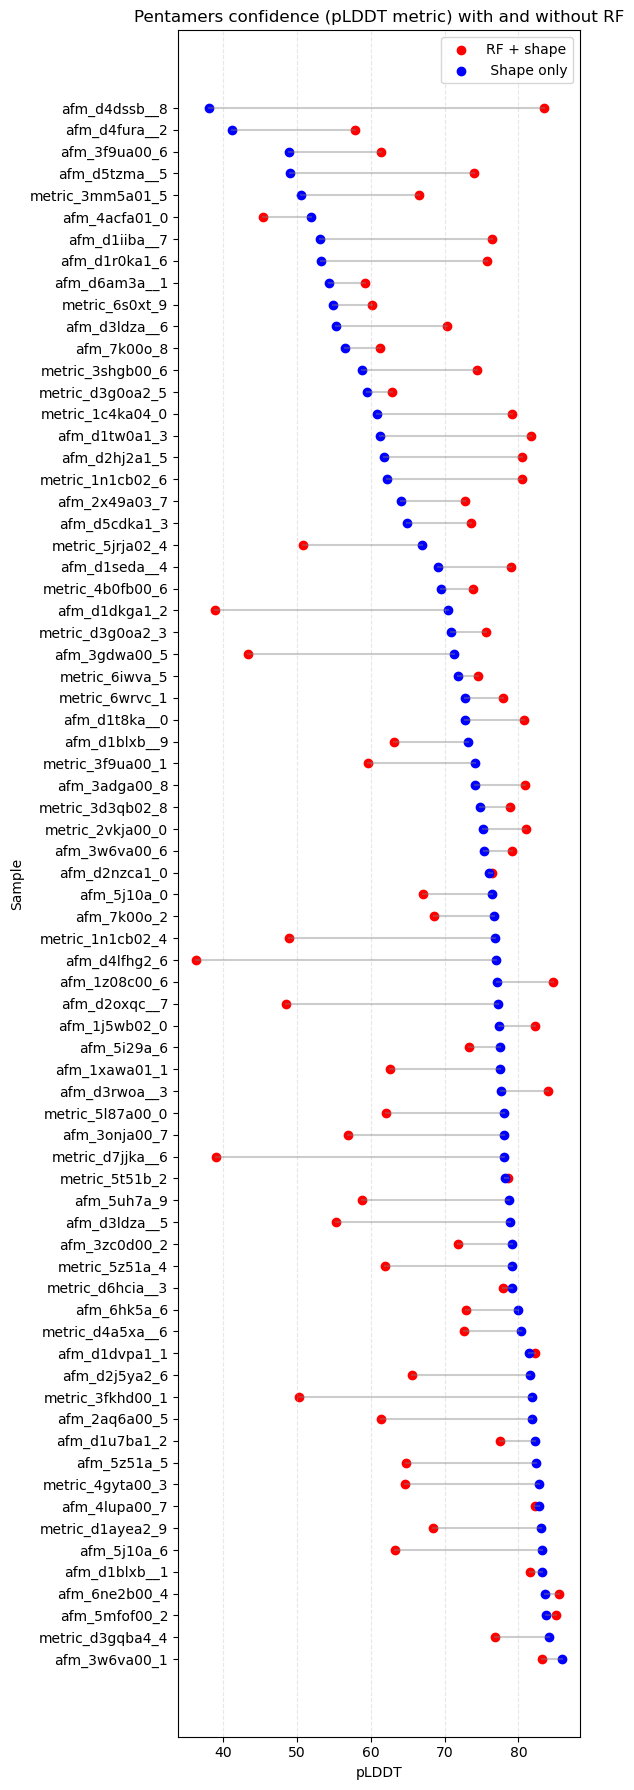

In [25]:
plot_paired(pentamer_df,"Tm_pred-ex_w","Tm_pred-ex_wo","Pentamers TM score predicted-extracted with and without RF","TM_score","RF + shape","Shape only","Tm_pred-ex_wo",size=(6,18))
plot_paired(pentamer_df,"pLDDT_w","pLDDT_wo","Pentamers confidence (pLDDT metric) with and without RF","pLDDT","RF + shape"," Shape only","pLDDT_wo",size=(6,18))

In [5]:
# Stats
dimer_dict = pd.DataFrame({
    'pLDDT_w': dimer_df['pLDDT_w'],
    'pLDDT_wo': dimer_df['pLDDT_wo'],
    'RMSD_w': dimer_df["RMSD_pred-ex_w"],
    'RMSD_wo': dimer_df["RMSD_pred-ex_wo"],
    'Tm_w': dimer_df["Tm_pred-ex_w"],
    'Tm_wo': dimer_df["Tm_pred-ex_wo"],
    'interface_w' : dimer_df["interface_w"],
    'interface_wo' : dimer_df["interface_wo"],
})
trimer_dict = pd.DataFrame({
    'pLDDT_w': trimer_df['pLDDT_w'],
    'pLDDT_wo': trimer_df['pLDDT_wo'],
    'RMSD_w': trimer_df["RMSD_pred-ex_w"],
    'RMSD_wo': trimer_df["RMSD_pred-ex_wo"],
    'Tm_w': trimer_df["Tm_pred-ex_w"],
    'Tm_wo': trimer_df["Tm_pred-ex_wo"],
})
pentamer_dict = pd.DataFrame({
    'pLDDT_w': pentamer_df['pLDDT_w'],
    'pLDDT_wo': pentamer_df['pLDDT_wo'],
    'RMSD_w': pentamer_df["RMSD_pred-ex_w"],
    'RMSD_wo': pentamer_df["RMSD_pred-ex_wo"],
    'Tm_w': pentamer_df["Tm_pred-ex_w"],
    'Tm_wo': pentamer_df["Tm_pred-ex_wo"],
})
dimer_plddt = statistics_columns(dimer_dict,'pLDDT_w','pLDDT_wo', paired = True, treshold=80)
dimer_rmsd = statistics_columns(dimer_dict,'RMSD_w','RMSD_wo', paired = True)
dimer_tm = statistics_columns(dimer_dict,'Tm_w','Tm_wo', paired = True, treshold=0.4)
trimer_plddt = statistics_columns(trimer_dict,'pLDDT_w','pLDDT_wo', paired = True, treshold=80)
trimer_rmsd = statistics_columns(trimer_dict,'RMSD_w','RMSD_wo', paired = True)
trimer_tm = statistics_columns(trimer_dict,'Tm_w','Tm_wo', paired = True, treshold=0.4)
pentamer_plddt = statistics_columns(pentamer_dict,'pLDDT_w','pLDDT_wo', paired = True, treshold=80)
pentamer_rmsd = statistics_columns(pentamer_dict,'RMSD_w','RMSD_wo', paired = True)
pentamer_tm = statistics_columns(pentamer_dict,'Tm_w','Tm_wo', paired = True, treshold=0.4)


In [7]:
print(dimer_plddt)
print(dimer_tm)
print(trimer_plddt)
print(trimer_tm)
print(pentamer_plddt)
print(pentamer_tm)

{'test': 'Wilcoxon signed-rank', 'p_value': 0.05915228967073587, 'star': 'ns', 'statistic': 1693.0, 'mean pLDDT_w': 73.54380170986911, 'mean pLDDT_wo': 77.11244717153026, 'over_treshold pLDDT_w': 44, 'over_treshold pLDDT_wo': 53, 'times pLDDT_w > pLDDT_wo': 37, 'times pLDDT_wo > pLDDT_w': 56, 'mean_difference': -3.5686454616611485, 'effect_size': -0.20430107526881724, 'normality': {'col1': 1.9606369700098844e-06, 'col2': 1.6490360838514916e-08}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 0.09144638382017853, 'star': 'ns', 'statistic': 1745.0, 'mean Tm_w': 0.4247006451612904, 'mean Tm_wo': 0.44770505376344094, 'over_treshold Tm_w': 59, 'over_treshold Tm_wo': 70, 'times Tm_w > Tm_wo': 40, 'times Tm_wo > Tm_w': 53, 'mean_difference': -0.023004408602150528, 'effect_size': -0.13978494623655918, 'normality': {'col1': 0.00343271107364204, 'col2': 8.107188266933278e-07}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 0.06107334735140066, 'star': 'n

/tmp/ipykernel_1338609/2999040393.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1338609/2999040393.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


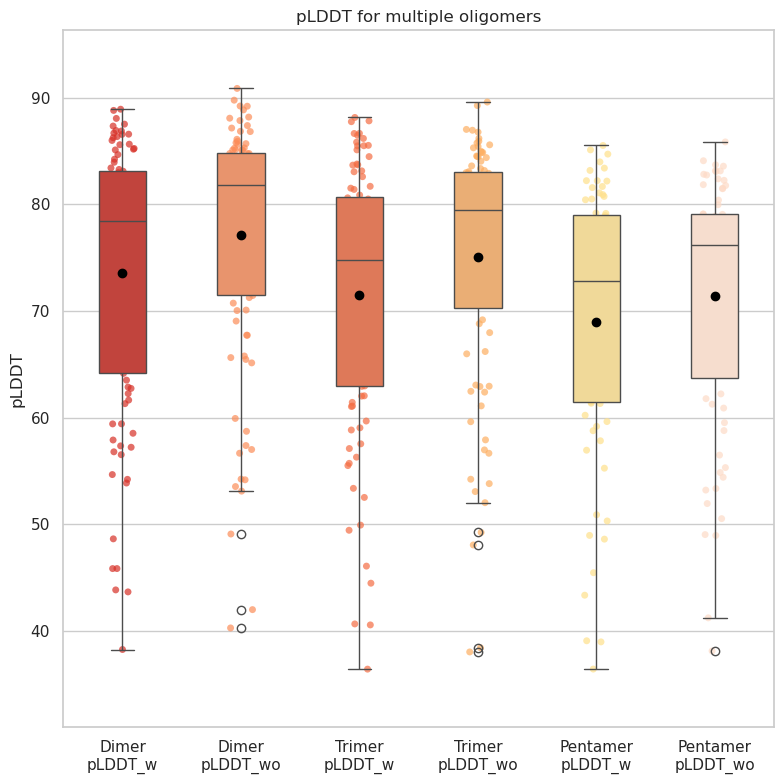

/tmp/ipykernel_1338609/2999040393.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1338609/2999040393.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


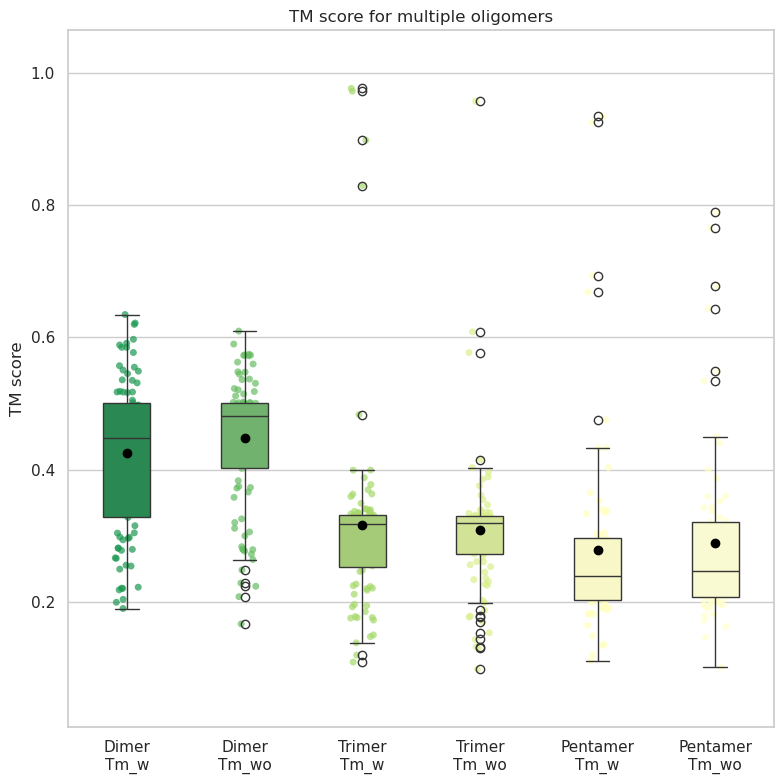

In [7]:
oligomer_boxplot_df = pd.DataFrame({
    'Dimer\npLDDT_w': dimer_df['pLDDT_w'],
    'Dimer\npLDDT_wo': dimer_df['pLDDT_wo'],
    'Dimer\nTm_w': dimer_df["Tm_pred-ex_w"],
    'Dimer\nTm_wo': dimer_df["Tm_pred-ex_wo"],
    'Trimer\npLDDT_w': trimer_df['pLDDT_w'],
    'Trimer\npLDDT_wo': trimer_df['pLDDT_wo'],
    'Trimer\nTm_w': trimer_df["Tm_pred-ex_w"],
    'Trimer\nTm_wo': trimer_df["Tm_pred-ex_wo"],
    'Pentamer\npLDDT_w': pentamer_df['pLDDT_w'],
    'Pentamer\npLDDT_wo': pentamer_df['pLDDT_wo'],
    'Pentamer\nTm_w': pentamer_df["Tm_pred-ex_w"],
    'Pentamer\nTm_wo': pentamer_df["Tm_pred-ex_wo"],
})
plddt_palette = {
    'Dimer\npLDDT_w' : "#d73027",     # intense red
    'Dimer\npLDDT_wo': "#fc8d59",     # orange-red
    'Trimer\npLDDT_w': "#f46d43",     # softer red-orange
    'Trimer\npLDDT_wo': "#fdae61",    # light orange
    'Pentamer\npLDDT_w': "#fee08b",   # very light orange
    'Pentamer\npLDDT_wo': "#fddbc7"   # peach
}
tmscore_palette = {
    'Dimer\nTm_w': "#1a9850",         # dark green
    'Dimer\nTm_wo': "#66bd63",        # medium green
    'Trimer\nTm_w': "#a6d96a",        # yellowish green
    'Trimer\nTm_wo': "#d9ef8b",       # pale yellow-green
    'Pentamer\nTm_w': "#ffffbf",      # light yellow
    'Pentamer\nTm_wo': "#ffffcc"      # pale yellow
}
boxplot(oligomer_boxplot_df,['Dimer\npLDDT_w','Dimer\npLDDT_wo','Trimer\npLDDT_w','Trimer\npLDDT_wo', 'Pentamer\npLDDT_w','Pentamer\npLDDT_wo'],"pLDDT",plddt_palette,"pLDDT for multiple oligomers","pLDDT",(8,8))
boxplot(oligomer_boxplot_df,['Dimer\nTm_w','Dimer\nTm_wo','Trimer\nTm_w','Trimer\nTm_wo','Pentamer\nTm_w','Pentamer\nTm_wo'],"TM score",tmscore_palette,"TM score for multiple oligomers","TM score",(8,8))

# CAPSIDS

In [5]:
capsids_shape_df = pd.read_csv("/home/eduardo/control_shapedesign_output_29-06/capsid_metrics.csv")
capsids_shape_RF_df = pd.read_csv("/home/eduardo/improved_shapedesign_output_1/capsid_metrics_2.csv")
capsids_shape_RF_df.head(15)

,Unnamed: 0,time,s,x,λ,ψ,θ,φ,ca_rmsd.monomer,score,...,sasa_polar.2_1fold_norm,sasa_polar.2_2fold_norm,sasa_hydrophobic.5fold_norm,sasa_hydrophobic.3fold_norm,sasa_hydrophobic.2_1fold_norm,sasa_hydrophobic.2_2fold_norm,sc.5fold_norm,sc.3fold_norm,sc.2_1fold_norm,sc.2_2fold_norm
0,0,1.750332e+09,63.411792,0.490774,-6.320294,1.820673,-11.042750,2.139474,0.900309,0.416600,...,0.580159,NaN,1.000000,0.138805,0.503701,NaN,0.665706,0.132123,1.000000,NaN
1,1,1.750336e+09,99.492630,5.481747,3.782075,7.799731,3.396277,0.774362,0.968001,0.324427,...,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
2,2,1.750337e+09,87.770293,6.226389,12.295344,1.293718,15.910227,2.473648,0.935807,0.338412,...,1.000000,NaN,NaN,0.091867,0.685064,NaN,NaN,1.000000,0.096004,NaN
3,3,1.750337e+09,69.352905,-2.191908,-5.995136,19.955941,-6.424047,-30.511683,0.753806,0.450841,...,1.000000,NaN,0.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN
4,4,1.750341e+09,100.856362,-0.857900,3.081605,-9.052239,-18.524685,20.323895,0.829211,0.300000,...,1.000000,NaN,0.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
5,5,1.750341e+09,100.945043,3.348276,5.992595,-6.206516,20.178722,-14.588298,1.564254,0.323462,...,NaN,NaN,NaN,0.746028,NaN,NaN,NaN,0.920244,NaN,NaN
6,6,1.750343e+09,88.613220,2.185576,7.041223,-24.174093,1.898072,-5.510429,0.725229,0.475412,...,0.619129,NaN,0.098056,1.000000,0.282839,NaN,0.989663,0.948029,1.000000,NaN
7,7,1.750347e+09,71.392423,-3.596082,-13.648027,25.476532,14.227736,-7.288944,0.674445,0.606533,...,0.035927,0.924403,1.000000,0.406400,0.024479,1.0,0.000000,0.635772,0.277888,1.0
8,8,1.750347e+09,34.096941,0.858962,-26.454415,8.746092,-150.742964,-15.636489,13.844250,0.347412,...,NaN,1.000000,0.531915,NaN,NaN,1.0,0.425536,NaN,NaN,0.0
9,9,1.750351e+09,99.100649,-3.463347,-9.213794,0.901787,-24.713351,18.710026,1.436447,0.345581,...,0.000000,NaN,1.000000,NaN,0.000000,NaN,0.911618,NaN,NaN,NaN


In [6]:
columns = [
        "ddg.5fold", "ddg.3fold", "ddg.2_1fold", "ddg.2_2fold",
        "sasa.5fold", "sasa.3fold", "sasa.2_1fold", "sasa.2_2fold",
        "sasa_polar.5fold", "sasa_polar.3fold", "sasa_polar.2_1fold", "sasa_polar.2_2fold",
        "sasa_hydrophobic.5fold", "sasa_hydrophobic.3fold", "sasa_hydrophobic.2_1fold", "sasa_hydrophobic.2_2fold",
        "sc.5fold", "sc.3fold", "sc.2_1fold", "sc.2_2fold"
    ]

capsids_shape_df = capsids_shape_df[columns]
capsids_shape_RF_df = capsids_shape_RF_df[columns]
capsids_shape_RF_df.head(15)

,ddg.5fold,ddg.3fold,ddg.2_1fold,ddg.2_2fold,sasa.5fold,sasa.3fold,sasa.2_1fold,sasa.2_2fold,sasa_polar.5fold,sasa_polar.3fold,sasa_polar.2_1fold,sasa_polar.2_2fold,sasa_hydrophobic.5fold,sasa_hydrophobic.3fold,sasa_hydrophobic.2_1fold,sasa_hydrophobic.2_2fold,sc.5fold,sc.3fold,sc.2_1fold,sc.2_2fold
0,-1.320269e+02,-1.935814e+01,-1.904311e+01,3.350243e-02,1153.085565,568.951143,297.624831,0.000000,326.841409,224.639583,326.439790,0.000000,827.280255,353.977796,268.809871,0.000000,0.523522,0.383188,0.648553,NaN
1,-3.028516e+02,8.740244e-10,5.825314e-10,5.825314e-10,2387.200888,0.000000,0.000000,0.000000,790.947535,0.000000,0.000000,0.000000,1562.557155,0.000000,0.000000,0.000000,0.561422,NaN,NaN,NaN
2,1.441549e-10,-2.653444e+01,-1.826879e+01,5.752554e-11,0.000000,393.809776,434.809533,0.000000,0.000000,130.082298,456.861264,0.000000,0.000000,277.678517,412.757802,0.000000,NaN,0.704363,0.225334,NaN
3,-3.708465e-10,-8.195971e+01,-6.213958e+01,-1.482476e-10,0.000000,871.257120,1157.252363,0.000000,0.000000,207.099605,585.102045,0.000000,0.000000,674.922165,1729.402680,0.000000,NaN,0.749536,0.685504,NaN
4,-4.486762e+01,-1.949047e-09,-5.191300e+01,-1.298758e-09,508.695195,0.000000,1280.223619,0.000000,94.632334,0.000000,979.089762,0.000000,416.118740,0.000000,1581.357477,0.000000,0.665514,NaN,0.569323,NaN
5,1.247599e-09,-1.461469e+02,4.989715e-10,4.990852e-10,0.000000,2023.428120,0.000000,0.000000,0.000000,512.208757,0.000000,0.000000,0.000000,1522.619453,0.000000,0.000000,NaN,0.641388,NaN,NaN
6,-8.196253e+01,-6.440953e+01,-1.898123e+01,7.266863e-10,572.157129,768.373444,394.400274,0.000000,214.479827,220.079037,347.381414,0.000000,363.624953,575.385510,441.419133,0.000000,0.622830,0.681071,0.780335,NaN
7,-6.200025e+01,-6.686564e+01,-6.951951e-01,-9.031355e-01,701.245032,1132.014823,38.682415,292.536059,305.821440,315.502199,30.407514,188.600085,393.549965,840.610498,46.957316,396.472034,0.415674,0.604670,0.176815,0.731952
8,-4.268808e+01,4.101821e-10,2.735305e-10,-9.024770e+00,278.027343,0.000000,0.000000,306.530963,98.181364,0.000000,0.000000,105.237342,181.510387,0.000000,0.000000,507.824583,0.581757,NaN,NaN,0.726238
9,-3.432570e+02,7.357812e-10,4.911271e-10,4.911271e-10,2680.511811,0.000000,0.000000,0.000000,850.733982,0.000000,0.000000,0.000000,1845.247831,0.000000,0.000000,0.000000,0.641134,NaN,NaN,NaN


In [7]:
def prepare_df(df_w, df_wo, types):
    result_df = pd.DataFrame()

    for var_type in types:
        # Filtra columnas que contienen el tipo
        cols_w = [col for col in df_w.columns if var_type in col]
        cols_wo = [col for col in df_wo.columns if var_type in col]

        # Extrae subconjuntos de columnas
        df_w_filtered = df_w[cols_w]
        df_wo_filtered = df_wo[cols_wo]

        # Aplica la función apropiada por fila
        if var_type == "ddg":
            list_w = df_w_filtered.min(axis=1)
            list_wo = df_wo_filtered.min(axis=1)
        else:
            list_w = df_w_filtered.max(axis=1)
            list_wo = df_wo_filtered.max(axis=1)

        # Agrega columnas al DataFrame de resultados
        result_df[f"{var_type}_w"] = list_w
        result_df[f"{var_type}_wo"] = list_wo

    return result_df

In [8]:
global_capsids = prepare_df(capsids_shape_RF_df, capsids_shape_df, ["ddg","sasa.","sasa_polar", "sasa_hydrophobic", "sc"])
global_capsids = global_capsids[global_capsids['ddg_w']<1000]
global_capsids = global_capsids[global_capsids['sasa_hydrophobic_w']<4000]
global_capsids.head(10)

,ddg_w,ddg_wo,sasa._w,sasa._wo,sasa_polar_w,sasa_polar_wo,sasa_hydrophobic_w,sasa_hydrophobic_wo,sc_w,sc_wo
0,-132.026932,-71.507918,1153.085565,1002.364755,326.841409,731.201230,827.280255,1273.528280,0.648553,0.695558
1,-302.851582,-140.535214,2387.200888,1219.842848,790.947535,408.946352,1562.557155,825.513455,0.561422,0.737361
2,-26.534445,-154.834583,434.809533,1141.347108,456.861264,494.559600,412.757802,646.596356,0.704363,0.700000
3,-81.959714,-79.181012,1157.252363,1310.874169,585.102045,528.488994,1729.402680,2093.259343,0.749536,0.687504
4,-51.912998,-77.663175,1280.223619,1038.046762,979.089762,364.014983,1581.357477,682.277572,0.665514,0.808722
5,-146.146872,-101.345107,2023.428120,1333.210794,512.208757,389.236155,1522.619453,1058.114974,0.641388,0.773364
6,-81.962526,-19.978422,768.373444,638.024249,347.381414,530.400712,575.385510,745.647785,0.780335,0.893974
7,-66.865641,-122.084601,1132.014823,1021.197997,315.502199,368.366671,840.610498,758.234045,0.731952,0.788810
8,-42.688084,-42.296151,306.530963,835.776095,105.237342,409.491670,507.824583,1262.060521,0.726238,0.685051
9,-343.257034,-188.015564,2680.511811,1205.501012,850.733982,356.864175,1845.247831,937.241180,0.641134,0.718591


In [9]:
capsids_ddg = statistics_columns(global_capsids,'ddg_w','ddg_wo', paired = True)
capsids_sasa = statistics_columns(global_capsids,'sasa._w','sasa._wo', paired = True)
capsids_sasa_polar = statistics_columns(global_capsids,'sasa_polar_w','sasa_polar_wo', paired = True)
capsids_sasa_hydro = statistics_columns(global_capsids,'sasa_hydrophobic_w','sasa_hydrophobic_wo', paired = True)
capsids_sc = statistics_columns(global_capsids,'sc_w','sc_wo', paired = True)
print(capsids_ddg )
print(capsids_sasa )
print(capsids_sasa_polar) 
print(capsids_sasa_hydro )
print(capsids_sc )

{'test': 'Wilcoxon signed-rank', 'p_value': 0.5714070053952209, 'star': 'ns', 'statistic': 1950.0, 'mean ddg_w': -118.1346365338895, 'mean ddg_wo': -121.75270245382363, 'over_treshold ddg_w': 5, 'over_treshold ddg_wo': 2, 'times ddg_w > ddg_wo': 48, 'times ddg_wo > ddg_w': 43, 'mean_difference': 3.618065919934125, 'effect_size': 0.05494505494505497, 'normality': {'col1': 1.014006138953827e-05, 'col2': 0.0026941043732466832}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 0.8742076145446718, 'star': 'ns', 'statistic': 2053.0, 'mean sasa._w': 1273.7024300665794, 'mean sasa._wo': 1279.0134527023688, 'over_treshold sasa._w': 91, 'over_treshold sasa._wo': 91, 'times sasa._w > sasa._wo': 47, 'times sasa._wo > sasa._w': 44, 'mean_difference': -5.3110226357894135, 'effect_size': 0.032967032967033016, 'normality': {'col1': 9.472041606667215e-07, 'col2': 2.6476442882014893e-07}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 0.7246480628244039, 'star': '

In [10]:
global_capsids.rename(columns={'sasa._w': 'sasa\nw'}, inplace=True)
global_capsids.rename(columns={'sasa_polar_w': 'sasa\npolar w'}, inplace=True)
global_capsids.rename(columns={'sasa_hydrophobic_w': "sasa\nhydrophobic w"}, inplace=True)
global_capsids.rename(columns={'sasa._wo': 'sasa\nwo'}, inplace=True)
global_capsids.rename(columns={'sasa_polar_wo': 'sasa\npolar wo'}, inplace=True)
global_capsids.rename(columns={'sasa_hydrophobic_wo': 'sasa\nhydrophobic wo'}, inplace=True)
global_capsids.head()

,ddg_w,ddg_wo,sasa\nw,sasa\nwo,sasa\npolar w,sasa\npolar wo,sasa\nhydrophobic w,sasa\nhydrophobic wo,sc_w,sc_wo
0,-132.026932,-71.507918,1153.085565,1002.364755,326.841409,731.201230,827.280255,1273.528280,0.648553,0.695558
1,-302.851582,-140.535214,2387.200888,1219.842848,790.947535,408.946352,1562.557155,825.513455,0.561422,0.737361
2,-26.534445,-154.834583,434.809533,1141.347108,456.861264,494.559600,412.757802,646.596356,0.704363,0.700000
3,-81.959714,-79.181012,1157.252363,1310.874169,585.102045,528.488994,1729.402680,2093.259343,0.749536,0.687504
4,-51.912998,-77.663175,1280.223619,1038.046762,979.089762,364.014983,1581.357477,682.277572,0.665514,0.808722


/tmp/ipykernel_1542928/2383796376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1542928/2383796376.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


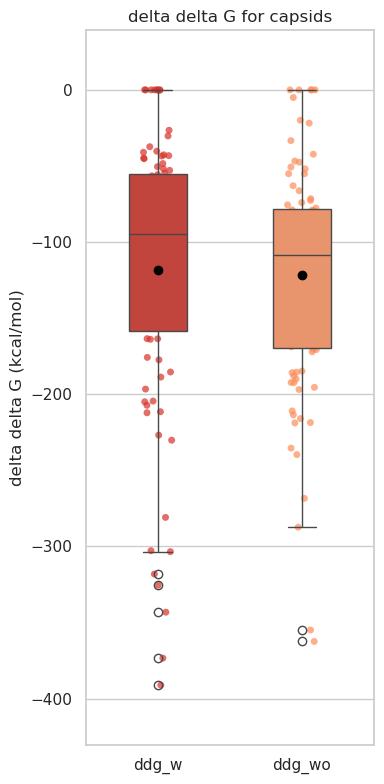

/tmp/ipykernel_1542928/2383796376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1542928/2383796376.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


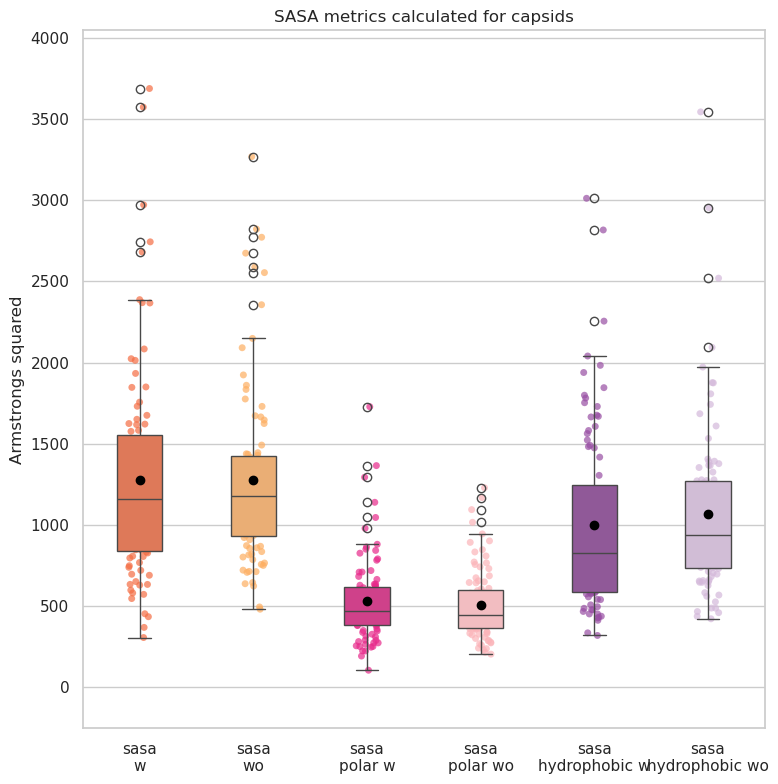

/tmp/ipykernel_1542928/2383796376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1542928/2383796376.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


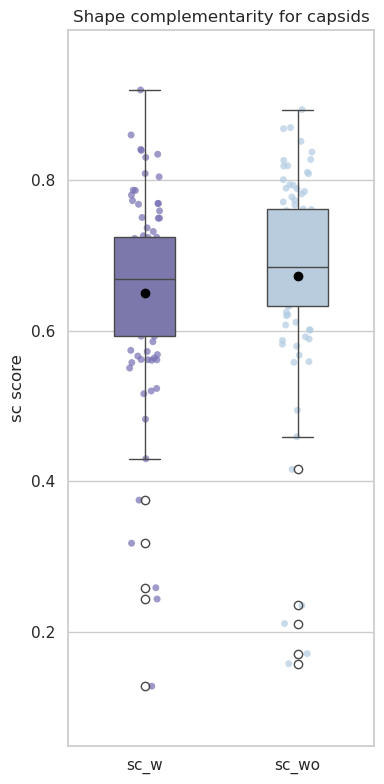

In [12]:


capsids_palette = {
    'ddg_w': "#d73027",              # strong red
    'ddg_wo': "#fc8d59",             # soft orange-red

    'sasa\nw': "#f46d43",            # purple
    'sasa\nwo': "#fdae61",           # light purple

    'sasa\npolar w': "#e7298a",       # pinkish magenta
    'sasa\npolar wo': "#fbb4b9",      # light pink

    'sasa\nhydrophobic w': "#984ea3", # orange-red
    'sasa\nhydrophobic wo': "#d4b9da",# light orange

    'sc_w': "#7570b3",               # indigo blue (cool contrast)
    'sc_wo': "#b3cde3"               # pale lavender-blue
}

boxplot(global_capsids, ['ddg_w','ddg_wo'], "delta delta G (kcal/mol)", capsids_palette, "delta delta G for capsids", "delta delta G (kcal/mol)", (4,8))
boxplot(global_capsids, ['sasa\nw', 'sasa\nwo', 'sasa\npolar w', 'sasa\npolar wo', 'sasa\nhydrophobic w', 'sasa\nhydrophobic wo'], "Armstrongs squared", capsids_palette, "SASA metrics calculated for capsids", "Armstrongs squared", (8,8))
boxplot(global_capsids, ['sc_w', 'sc_wo'], "sc score", capsids_palette, "Shape complementarity for capsids", "sc score", (4,8))

### ddg

In [ ]:
plot_df = pd.DataFrame({
    "ddg.5fold_wo": capsids_shape_df["ddg.5fold"],
    'stab_RF': capsids_shape_RF_df ['delta_G'] ,
    'hydro_orig' : capsids_shape_df["ddg.3fold", "ddg.2_1fold", "ddg.2_2fold",] ,
    'hydro_RF' : capsids_shape_RF_df ['hydro_RF'] ,
    'sol_orig' : capsids_shape_df['sol_orig'] ,
    'sol_RF' : capsids_shape_RF_df ['sol_RF']
})

### sasa

### sasa_polar

### sasa_hydrophobic

### shape complementarity